In [1]:


import numpy as np
import pandas as pd
#import torch
import matplotlib.pyplot as plt
import matplotlib
import os
import sklearn
import sklearn.model_selection

import pymc as pm
import arviz as az

%matplotlib inline



In [2]:
print(pm.__version__)

4.2.1


In [3]:
# load specific MB mean for different MB model parameters (i.e. temp_b & melt_f, here done as a test for the Aletsch glacier): 
# choose the one with a fixed pf but variable temp. b and melt factors
pd_spec_mb = pd.read_csv('test_mb_RGI60-11.01450_fixed_pf_test.csv', index_col=[0])

# too many values make the notebook slow ... I just removed some parameters again ... 
pd_spec_mb = pd_spec_mb.sort_values(by=['melt_f', 'temp_bias']).iloc[1::3]
pd_spec_mb = pd_spec_mb.sort_values(by=['temp_bias','melt_f']).iloc[::2]

# applied MB model parameters that were used to estimated the real OGGM MB model (partly used for training the emulator)  
X = pd_spec_mb[['temp_bias','melt_f'] ].values 

# modelled specific mean MB (mean over 2000-2020) estimated from the real OGGM MB model (partly used for training the emulator) 
# we later want to match this value (i.e. y) with the geodetic observation 
y = pd_spec_mb['spec_mb_mean'].values



In [4]:
pd_spec_mb[['temp_bias','melt_f', 'spec_mb_mean']]

,temp_bias,melt_f,spec_mb_mean
99,-9.95,15.0,4447.609466
101,-9.95,35.0,4442.662098
103,-9.95,55.0,4437.714730
105,-9.95,75.0,4432.767362
107,-9.95,95.0,4427.819994
...,...,...,...
19791,9.85,915.0,-74043.378533
19793,9.85,935.0,-75693.041314
19795,9.85,955.0,-77342.704096
19797,9.85,975.0,-78992.366877


In [5]:
random_state = 42 
### similar as what David Rounce does in PyGEM:

# normalize parameter data used inside "real" MB model (partly used for training the emulator) 
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

# normalize modelled MB data from "real" MB model (partly used for training the emulator) 
y_mean = y.mean()
y_std = y.std()
y_norm = (y - y_mean) / y_std

# Split into training and test data (but witout having torch tensors ... )
X_train_pm,X_test_pm,y_train_pm,y_test_pm = sklearn.model_selection.train_test_split(X_norm,y_norm, test_size=0.8)

In [6]:
sigma_geo = [171]
y_geo = [-1210]

In [7]:
X_sim = X_train_pm
y_sim = y_train_pm

In [8]:
with pm.Model() as model_dummy:
    
    #define the covariance parameters and function
    input_dim = 2 #number of input variables
    cov = pm.gp.cov.ExpQuad(input_dim, ls=0.1)
    
    #instantiate latent GP
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('latent_gp', X=X_sim, 
                       jitter=1e-7)

    gp_sigma = pm.HalfNormal('gp_sigma', sigma=2.0)
    nu = 1 + pm.Gamma('nu', alpha=2, beta=0.1)

    y_ = pm.StudentT('y', mu=f, lam=1.0 / gp_sigma, nu=nu, 
                                 observed=y_sim)

    #latent_trace = pm.sample(1000, chains=2, target_accept=0.9, cores=1)


In [9]:
sigma_obs = [171]
y_obs = [-1210]

In [10]:
with model_dummy:

    #define the "observational" distributions for inputs to gp.conditional     
    dim1 = pm.TruncatedNormal('dim1_fit', 
                                                   mu=0, sigma=2,
                                                   lower=-8, upper=8)
    dim2 = pm.TruncatedNormal('dim2_fit',
                                                   mu=250, sigma=200,
                                                   lower=1, upper=1000)
    
    dim1_t = pm.draw(dim1,1000)
    dim2_t = pm.draw(dim2,1000)


    Xnew = np.array([dim1_t, dim2_t])
    
    #instantiate the conditional fit of GP to new "data"
    gp_mu = gp.conditional('conditional_fit', Xnew=Xnew)


    #sigma_obs and y_obs are both lists with len=1
    sigma = pm.Data('sigma', sigma_obs) 
    observed = pm.Data('observed', y_obs)
    log_l = pm.Normal('log_mb', mu=gp_mu, sigma=sigma,
                                  observed=observed)

/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/gp/cov.py:99: UserWarning: Only 2 column(s) out of 1000 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [11]:
with model_dummy:
    trace = pm.sample(1000, chains=2, target_accept=0.9, cores=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [latent_gp_rotated_, gp_sigma, nu, dim1_fit, dim2_fit, conditional_fit]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 664 seconds.
The acceptance probability does not match the target. It is 0.4303, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7181, but should be close to 0.9. Try to increase the number of tuning steps.


In [15]:
random_seed = 42

In [32]:
model_dummy.log_mb

log_mb ~ N(conditional_fit, f())

In [26]:
pm.sample_posterior_predictive?

Signature:
pm.sample_posterior_predictive(
    trace,
    samples: Optional[int] = None,
    model: Optional[pymc.model.Model] = None,
    var_names: Optional[List[str]] = None,
    keep_size: Optional[bool] = None,
    random_seed: Union[int, Sequence[int], numpy.ndarray, NoneType, numpy.random.mtrand.RandomState, numpy.random._generator.Generator] = None,
    progressbar: bool = True,
    return_inferencedata: bool = True,
    extend_inferencedata: bool = False,
    predictions: bool = False,
    idata_kwargs: dict = None,
    compile_kwargs: dict = None,
) -> Union[arviz.data.inference_data.InferenceData, Dict[str, numpy.ndarray]]
Docstring:
Generate posterior predictive samples from a model given a trace.

Parameters
----------
trace : backend, list, xarray.Dataset, arviz.InferenceData, or MultiTrace
    Trace generated from MCMC sampling, or a list of dicts (eg. points or from find_MAP()),
    or xarray.Dataset (eg. InferenceData.posterior or InferenceData.prior)
samples : int
   

In [25]:
with model_dummy:
    ppc2 = pm.sample_posterior_predictive(trace, #cores=cores,
                                         random_seed=random_seed,
                                         #var_names=['log_mb'
                                         #           #'dim1_fit', 'dim2_fit',
                                         #           #'mu',
                                         #          ]
                                         ) #keep_size=True)

Sampling: [log_mb, y]


ValueError: Output size (1,) is not compatible with broadcast dimensions of inputs (2,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F46035D6F20>), TensorConstant{(1,) of 1}, TensorConstant{11}, conditional_fit, TensorConstant{(1,) of 171.0})
Toposort index: 3
Inputs types: [RandomGeneratorType, TensorType(int64, (1,)), TensorType(int64, ()), TensorType(float64, (None,)), TensorType(float64, (1,))]
Inputs shapes: ['No shapes', (1,), (), (2,), (1,)]
Inputs strides: ['No strides', (8,), (), (8,), (8,)]
Inputs values: [Generator(PCG64) at 0x7F46035D6F20, array([1]), array(11), array([-1.56729691, -1.43240702]), array([171.])]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most Aesara optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the Aesara flag 'optimizer=fast_compile'. If that does not work, Aesara optimizations can be disabled with 'optimizer=None'.
HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
az.plot_trace(ppc2.posterior_predictive)

array([[<AxesSubplot: title={'center': 'dim1_fit'}>,
        <AxesSubplot: title={'center': 'dim1_fit'}>],
       [<AxesSubplot: title={'center': 'dim2_fit'}>,
        <AxesSubplot: title={'center': 'dim2_fit'}>]], dtype=object)

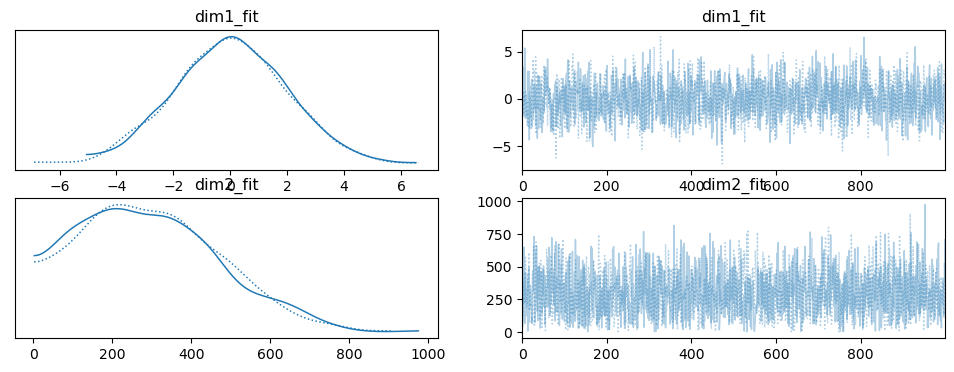

In [21]:
az.plot_trace(ppc.posterior_predictive)

In [13]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [48]:
import xarray as xr

In [50]:
path = '/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/per_glacier_calib_data/oggm_folder_projections/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/gcm_data_mri-esm2-0_r1i1p1f1_ssp585_bc_2000_2019.nc'
xr.open_dataset(path)

<xarray.Dataset>
Dimensions:   (time: 3012)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2100-12-01
Data variables:
    prcp      (time) float32 ...
    temp      (time) float32 ...
    gradient  (time) float32 ...
    temp_std  (time) float32 ...
Attributes:
    ref_hgt:         2252.0
    ref_pix_lon:     10.75
    ref_pix_lat:     46.75
    ref_pix_dis:     5629.566753389074
    climate_source:  _mri-esm2-0_r1i1p1f1_ssp585_bc_2000_2019_historical_mont...
    hydro_yr_0:      1850
    hydro_yr_1:      2100
    author:          OGGM
    author_info:     Open Global Glacier Model

In [53]:
path_w5e5 = '/home/lilianschuster/Schreibtisch/PhD/Schuster_et_al_phd_paper_1/data/per_glacier_calib_data/oggm_folder_projections/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/climate_historical_daily_W5E5.nc'

In [ ]:
ref_hgt=2

In [54]:
xr.open_dataset(path_w5e5)

<xarray.Dataset>
Dimensions:   (time: 14975)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    prcp      (time) float32 ...
    temp      (time) float32 ...
    gradient  (time) float32 ...
Attributes:
    ref_hgt:         2252.0
    ref_pix_lon:     10.75
    ref_pix_lat:     46.75
    ref_pix_dis:     5629.566753389074
    climate_source:  temp: W5E5_daily, prcp: W5E5_daily, lapse rate: ERA5dr
    hydro_yr_0:      1979
    hydro_yr_1:      2019
    author:          OGGM
    author_info:     Open Global Glacier Model

In [46]:
type(dim1)

aesara.tensor.var.TensorVariable

In [42]:
gp_mu

conditional_fitt ~ N(f(latent_gp_rotated_), f())

In [33]:


with pm.Model() as model:
    
    #define the covariance parameters and function
    input_dim = 2 #number of fit variables
    cov = pm.gp.cov.ExpQuad(input_dim, ls=0.1)
    
    #instantiate latent GP
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('latent_gp', X=X_train_pm, 
                 jitter=1e-7)
    
    #assuming marginal GP likelihood is normally distributed
    gp_likelihood = pm.Normal('gp_likelihood', mu=f, observed=y_train_pm)

    #assuming marginal GP likelihood is student-t distributed
    # gp_sigma = pm.HalfNormal('gp_sigma', sigma=2.0)
    # nu = 1 + pm.Gamma('nu', alpha=2, beta=0.1)
    # y_ = pm.StudentT('y', mu=f, lam=1.0/gp_sigma, nu=nu, 
    #                  observed=y_train_pm)

    # #assuming GP has some scatter
    # gp_sigma = pm.HalfCauchy('gp_sigma', beta=3)
    # latent_likelihood = gp.marginal_likelihood('gp_likelihood', 
    #                                            X=X_train_pm, y=y_train_pm, 
    #                                            sigma=gp_sigma)

    #latent_trace = pm.sample(500, chains=2, target_accept=0.9, cores=1)



In [34]:

with model:
    
    #define the "observational" variables for the geodetic best fit
    sigma = pm.Data('sigma', sigma_geo)      
    t_b = pm.TruncatedNormal('t_b', mu=0, sigma=2,
                            lower=-8, upper=8)
    melt_f = pm.TruncatedNormal('melt_f',
                                mu=250,
                                sigma=200,
                                lower=1, upper=1000)
    
    #Xnew = np.array([t_b, melt_f]).T #[:,None]
    
    Xnew = np.array([pm.draw(t_b, 1000),
                     pm.draw(melt_f, 1000)]) #[:,None]
    
    #instantiate the conditional fit of GP to new "data"
    gp_mu = gp.conditional('conditional_fit', Xnew=Xnew)
    
    #specify the manifest model
    observed = pm.Data('observed', y_geo)
    log_l = pm.Normal('log_mb', mu=gp_mu, sigma=sigma,
                      observed=observed)



/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/gp/cov.py:99: UserWarning: Only 2 column(s) out of 1000 are being used to compute the covariance function. If this is not intended, increase 'input_dim' parameter to the number of columns to use. Ignore otherwise.
  warnings.warn(
/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to usi

In [36]:
with model:
    trace = pm.sample(500, chains=2, target_accept=0.9, cores=1)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [latent_gp_rotated_, t_b, melt_f, conditional_fit]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 146 seconds.


In [38]:
trace.posterior.melt_f.mean()

<xarray.DataArray 'melt_f' ()>
array(290.5613954)

In [42]:
with model:
    ppc2 = pm.sample_posterior_predictive(trace, #cores=cores,
                                         random_seed=random_seed,
                                        var_names=['log_mb',
                                                    't_b', 'melt_f']
                                          
                                         )

TypeError: sample_posterior_predictive() got an unexpected keyword argument 'exception_verbosity'

In [78]:
model.free_RVs

[latent_gp_rotated_ ~ N(0, 1),
 t_b ~ TruncatedNormal(0, 2, -8, 8),
 melt_f ~ TruncatedNormal(250, 200, 1, 1e+03),
 conditional_fit ~ N(f(latent_gp_rotated_), f())]

In [80]:
with model:
    trace = pm.sample(500, chains=2, target_accept=0.9, cores=1, return_inferencedata=True) #) #log_l

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [latent_gp_rotated_, t_b, melt_f, conditional_fit]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 135 seconds.


In [131]:
y_obs

[-1210]

In [136]:
pd_spec_mb.loc[pd_spec_mb.temp_bias[60*28:60*29].index]

/tmp/ipykernel_17652/3278347321.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pd_spec_mb.loc[pd_spec_mb.temp_bias[60*28:60*29].index]


,prcp_fac,melt_f,temp_bias,spec_mb_mean
9993,1.776515,945.0,-0.05,-11147.199372
9995,1.776515,965.0,-0.05,-11459.241920
9997,1.776515,985.0,-0.05,-11771.284469
10197,1.776515,15.0,0.25,3283.680028
10199,1.776515,35.0,0.25,2947.345616
10201,1.776515,55.0,0.25,2611.011204
10203,1.776515,75.0,0.25,2274.676792
10205,1.776515,95.0,0.25,1938.342380
10207,1.776515,115.0,0.25,1602.007968
10209,1.776515,135.0,0.25,1265.673556


In [129]:
pd_spec_mb.loc[pd_spec_mb.temp_bias[60*27+20:60*28].index]

/tmp/ipykernel_17652/1729185883.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pd_spec_mb.loc[pd_spec_mb.temp_bias[60*27+20:60*28].index]


,prcp_fac,melt_f,temp_bias,spec_mb_mean
9913,1.776515,145.0,-0.05,1334.502566
9915,1.776515,165.0,-0.05,1022.460018
9917,1.776515,185.0,-0.05,710.417469
9919,1.776515,205.0,-0.05,398.374921
9921,1.776515,225.0,-0.05,86.332372
9923,1.776515,245.0,-0.05,-225.710176
9925,1.776515,265.0,-0.05,-537.752725
9927,1.776515,285.0,-0.05,-849.795273
9929,1.776515,305.0,-0.05,-1161.837822
9931,1.776515,325.0,-0.05,-1473.880370


In [102]:
pd_spec_mb.where(pd_spec_mb.temp_bias==-0.05).dropna()

,prcp_fac,melt_f,temp_bias,spec_mb_mean


In [132]:
trace.posterior.melt_f.median()

<xarray.DataArray 'melt_f' ()>
array(278.14733492)

In [133]:
trace.posterior.t_b.median()

<xarray.DataArray 't_b' ()>
array(-0.010458)

In [91]:
trace.posterior['conditional_fit'].mean(dim='draw')

<xarray.DataArray 'conditional_fit' (chain: 2, conditional_fit_dim_0: 2)>
array([[-0.66392046, -0.03777574],
       [-0.78536323, -0.03473706]])
Coordinates:
  * chain                  (chain) int64 0 1
  * conditional_fit_dim_0  (conditional_fit_dim_0) int64 0 1

In [60]:

with model:
    
    #define the "observational" variables for the geodetic best fit
    sigma = pm.Data('sigma', sigma_geo)      
    t_b = pm.TruncatedNormal('t_b', mu=0, sigma=2,
                            lower=-8, upper=8)
    melt_f = pm.TruncatedNormal('melt_f',
                                mu=250,
                                sigma=200,
                                lower=1, upper=1000)
    
    Xnew = np.array([t_b, melt_f]).T #[:,None]
    
    #Xnew = np.array([pm.draw(t_b, 1000),
    #                 pm.draw(melt_f, 1000)]).T #[:,None]
    
    #instantiate the conditional fit of GP to new "data"
    gp_mu = gp.conditional('conditional_fit', Xnew=Xnew)
    
    #specify the manifest model
    observed = pm.Data('observed', y_geo)
    log_l = pm.Normal('log_mb', mu=gp_mu, sigma=sigma,
                      observed=observed)



/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [51]:

with model:
    
    #define the "observational" variables for the geodetic best fit
    sigma = pm.Data('sigma', sigma_geo)      
    t_b = pm.TruncatedNormal('t_b', mu=0, sigma=2,
                            lower=-8, upper=8)
    melt_f = pm.TruncatedNormal('melt_f',
                                mu=250,
                                sigma=200,
                                lower=1, upper=1000)
    
    Xnew = np.array([pm.draw(t_b, 1000),
                     pm.draw(melt_f, 1000)]) #[:,None]
    
    #instantiate the conditional fit of GP to new "data"
    gp_mu = gp.conditional('conditional_fit', Xnew=Xnew.T)
    
    #specify the manifest model
    observed = pm.Data('observed', y_geo)
    log_l = pm.Normal('log_mb', mu=gp_mu, sigma=sigma,
                      observed=observed)



/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


In [58]:
log_l

log_mb ~ N(conditional_fit, f())

In [52]:
pm.draw?

Signature:
pm.draw(
    vars: Union[aesara.graph.basic.Variable, Sequence[aesara.graph.basic.Variable]],
    draws: int = 1,
    random_seed: Union[int, Sequence[int], numpy.ndarray, NoneType, numpy.random.mtrand.RandomState, numpy.random._generator.Generator] = None,
    **kwargs,
) -> Union[numpy.ndarray, List[numpy.ndarray]]
Docstring:
Draw samples for one variable or a list of variables

Parameters
----------
vars : TensorVariable or iterable of TensorVariable
    A variable or a list of variables for which to draw samples.
draws : int, default 1
    Number of samples needed to draw.
random_seed : int, RandomState or numpy_Generator, optional
    Seed for the random number generator.
**kwargs : dict, optional
    Keyword arguments for :func:`pymc.aesaraf.compile_pymc`.

Returns
-------
list of ndarray
    A list of numpy arrays.

Examples
--------
    .. code-block:: python

        import pymc as pm

        # Draw samples for one variable
        with pm.Model():
            x = 

## Try any kind of simple fit and put it then into the pymc stuff

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=20)
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
import scipy
# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
import numpy as np
import pandas as pd
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, TIModel, process_w5e5_data)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data, process_isimip_data_no_corr
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf,
                                 minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb)
from MBsandbox.mbmod_daily_oneflowline import compile_fixed_geometry_mass_balance_TIModel
import time
import logging

log = logging.getLogger(__name__)

climate_type = 'W5E5'

# get the geodetic calibration data
pd_geodetic_all = utils.get_geodetic_mb_dataframe()
# pd_geodetic_all = pd.read_hdf(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']


#pd_wgms_ref_glac_analysis = pd.read_csv('/home/lilianschuster/Schreibtisch/PhD/wgms_data_analysis/wgms_data_analysis.csv', index_col=[0])
#rgis_w_mb_profiles = pd_wgms_ref_glac_analysis[pd_wgms_ref_glac_analysis.MB_profile.dropna()].index

import MBsandbox
fp = utils.file_downloader('https://cluster.klima.uni-bremen.de/~lschuster/ref_glaciers' +
                           '/data/mb_overview_seasonal_mb_time_periods_20220301.csv')
pd_mb_overview = pd.read_csv(fp, index_col='Unnamed: 0')
fp_stats = utils.file_downloader('https://cluster.klima.uni-bremen.de/~lschuster/ref_glaciers' +
                           '/data/wgms_data_stats_20220301.csv')
pd_wgms_data_stats = pd.read_csv(fp_stats, index_col='Unnamed: 0')
# should have at least 5 annual MB estimates in the time period 1980-2019
# (otherwise can also not have MB profiles or winter MB!)
pd_wgms_data_stats = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>=5]
ref_candidates = pd_wgms_data_stats.rgi_id.unique()

# for tests
#testing = testing
#if testing:
#    ref_candidates = ['RGI60-11.01450'] #rgis_w_mb_profiles #oggm.utils.get_ref_mb_glaciers_candidates()
#    working_dir = utils.gettempdir(dirname='OGGM_seasonal_mb_calib', reset=True)
#else:
working_dir = '/home/lilianschuster/Schreibtisch/PhD/bayes_2022/oct_2022_emulator/'
#utils.gettempdir(dirname='OGGM_seasonal_mb_calib', reset=False)

cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True #True
cfg.PATHS['working_dir'] = working_dir
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1
cfg.PARAMS['continue_on_error'] = False
warnings.filterwarnings("ignore", category=DeprecationWarning) 

correction = False

/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/rewriting.py:13: DeprecationWarning: `ShapeFeature` is now located in `aesara.tensor.rewriting.shape`.
  from aesara.tensor.rewriting.basic import (
/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/utils.py:21: DeprecationWarning: `ShapeFeature` is now located in `aesara.tensor.rewriting.shape`.
  from aesara.tensor.rewriting.basic import ShapeFeature, topo_constant_folding
/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/aeppl/printing.py:29: DeprecationWarning: `ShapeFeature` is now located in `aesara.tensor.rewriting.shape`.
  from aesara.tensor.rewriting.basic import ShapeFeature
2022-10-24 12:17:50: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-10-24 12:17:50: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-10-24 12:17:50: oggm.cfg: Multiprocessing: using all available proc

In [2]:
from oggm.core import massbalance, climate


In [3]:
rgi_id = 'RGI60-11.01450'


In [4]:
cfg.PARAMS['border'] = 10
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/elev_bands/w5e5/qc0/pcpwin/match_geod_pergla'

load = False
if load:    
    gdirs = workflow.init_glacier_directories(['RGI60-11.01450'], 
                                              from_prepro_level=3, prepro_base_url=base_url)

    t=workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    t=workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
    #if baseline_climate == 'W5E5':
    #if mb_type != 'mb_monthly':

    #t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
    #                              temporal_resol='monthly')
    #else:
    #t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
    #                          temporal_resol='daily')
    #t = workflow.execute_entity_task(process_era5_daily_data, gdirs, #climate_type=baseline_climate,
                              #temporal_resol='daily'process_era5_daily_data(gd)
    #                                )
else:
    rgi_id = 'RGI60-11.01450'
    gdirs = workflow.init_glacier_directories(['RGI60-11.01450'])

2022-10-24 12:17:55: oggm.cfg: PARAMS['border'] changed from `40` to `10`.
2022-10-24 12:17:55: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


In [5]:
#import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import MBsandbox
from MBsandbox.wip import bayes_calib_geod_direct
from oggm import cfg, utils, workflow, tasks, graphics


In [6]:
load = False
if load:
    pd_spec_mb_gcm_vs_w5e5 = pd.DataFrame(np.nan, index=np.arange(0, 1000000), #*len(gdirs))),
                                columns=['rgi_id', 'gcm', 'ssp',
                                        'spec_mb_2000_2019_gcm', 'spec_mb_2000_2019_w5e5',
                                         'spec_mb_2000_2019_obs', 'apply_bias_correction'])


    hgts, widths = gdir.get_inversion_flowline_hw()
    mb_mod = massbalance.PastMassBalance(gdir)
    spec_mb_2000_2019_w5e5 = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                    year=np.arange(2000, 2019 + 1, 1)).mean()
    spec_mb_2000_2019_obs = pd_geod.loc[gdir.rgi_id].dmdtda*1000

In [7]:
import datetime
start_time = datetime.datetime.now()

columns = ['prcp_fac', 'melt_f', 'temp_bias', 'spec_mb_mean']
#columns = [*columns, *np.arange(2000, 2020,1).astype(str)]
#melt_f = 200
#spec_mbs = {}
load = False
if load:
    j = 0
    gdir = gdirs[0]

    pf_winter = oggm.core.climate.decide_winter_precip_factor(gdir)

    hgts, widths = gdir.get_inversion_flowline_hw()
    mb_mod = massbalance.PastMassBalance(gdir)
    
    pd_spec_mb = pd.DataFrame(columns = columns)
    for temp_bias in np.arange(-10, 10, 0.1):
        for prcp_fac in [pf_winter]:
            for melt_f in np.arange(10,1000, 10):
                mb_mod.prcp_fac = prcp_fac
                mb_mod.mu_star = melt_f
                mb_mod.temp_bias = temp_bias

                # just check if calibration worked ...
                spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                 year=np.arange(2000, 2020, 1))
                spec_mb_mean = spec_mb.mean()

                #spec_mbs[prcp_fac] = spec_mb
                pd_spec_mb.loc[j] = np.array([prcp_fac, melt_f, temp_bias, spec_mb_mean]) # , spec_mb))

                j+=1

    end_time = datetime.datetime.now()
    pd_spec_mb.to_csv(f'test_mb_{gdir.rgi_id}_fixed_pf.csv')
    #pd_spec_mb_sfc.to_csv('test_mb_sfc.csv')
else:
    pd_spec_mb = pd.read_csv(f'test_mb_{rgi_id}_fixed_pf.csv', index_col=[0])


In [72]:
utils.get_geodetic_mb_dataframe().loc[gdir.rgi_id]

,period,area,dmdtda,err_dmdtda,reg,is_cor
rgiid,,,,,,
RGI60-11.01450,2000-01-01_2010-01-01,82206000.0,-1.1896,0.1938,11,False
RGI60-11.01450,2000-01-01_2020-01-01,82206000.0,-1.2107,0.1315,11,False
RGI60-11.01450,2010-01-01_2020-01-01,82206000.0,-1.2317,0.1715,11,False


In [12]:
import datetime
start_time = datetime.datetime.now()

columns = ['prcp_fac', 'melt_f', 'temp_bias', 'spec_mb_mean']
#columns = [*columns, *np.arange(2000, 2020,1).astype(str)]
#melt_f = 200
#spec_mbs = {}
load = False
gdir = gdirs[0]

pf_winter = oggm.core.climate.decide_winter_precip_factor(gdir)

hgts, widths = gdir.get_inversion_flowline_hw()
mb_mod = massbalance.PastMassBalance(gdir)
if load:
    j = 0

    
    pd_spec_mb_test = pd.DataFrame(columns = columns)
    for temp_bias in np.arange(-10.05, 10.05, 0.1):
        for prcp_fac in [pf_winter]:
            for melt_f in np.arange(15,1000, 10):
                mb_mod.prcp_fac = prcp_fac
                mb_mod.mu_star = melt_f
                mb_mod.temp_bias = temp_bias


                # just check if calibration worked ...
                spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                 year=np.arange(2000, 2020, 1))
                spec_mb_mean = spec_mb.mean()

                #spec_mbs[prcp_fac] = spec_mb
                pd_spec_mb_test.loc[j] = np.array([prcp_fac, melt_f, temp_bias, spec_mb_mean]) # , spec_mb))

                j+=1

    end_time = datetime.datetime.now()
    pd_spec_mb_test.to_csv(f'test_mb_{gdir.rgi_id}_fixed_pf_test.csv')
    #pd_spec_mb_sfc.to_csv('test_mb_sfc.csv')
else:
    pd_spec_mb_test = pd.read_csv(f'test_mb_{rgi_id}_fixed_pf_test.csv', index_col=[0])
    # too many values ... 
    pd_spec_mb = pd_spec_mb_test.sort_values(by=['melt_f', 'temp_bias']).iloc[1::3]
    pd_spec_mb = pd_spec_mb.sort_values(by=['temp_bias','melt_f']).iloc[::2]

In [22]:
import aesara

In [24]:
ityp_l = [tt.dscalar, tt.dscalar]
otyp = at.dscalar
@aesara.compile.ops.as_op(itypes=ityp_l, otypes=[otyp])
def my_mb_model(X): #mb_mod
    melt_f, t_b = X
    mb_mod.temp_bias = t_b
    mb_mod.mu_star = melt_f
    spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                                 year=np.arange(2000, 2020, 1))
    return spec_mb.mean()

# this here is 
def my_mb_model_loglike(X, mb_mod, data, sigma):
    model = my_mb_model(theta, mb_mod)
    return -(0.5 / sigma**2) * np.sum((data - model) ** 2)

In [29]:
import pymc as pm

In [49]:
# if I want to debug aesara can set that to 'on' or 'warn'
aesara.config.compute_test_value = 'off' # Use 'warn' to activate this feature

In [88]:
# somehow it works (slowly) in case of TIModel but not for PastMassBalance model --> not really sure why....
mb_mod = TIModel(gdir, 150, mb_type='mb_monthly', prcp_fac=mb_mod.prcp_fac,
                    grad_type='cte', input_filesuffix='')

/home/lilianschuster/massbalance-sandbox/MBsandbox/mbmod_daily_oneflowline.py:1044: UserWarning: you changed the default input_filesuffix of the climate,make sure that the default climate (without filesuffix)is what you want and is compatible to the chosen temporal resolution!
  warnings.warn('you changed the default input_filesuffix of the climate,'


In [97]:
### dummy simplified model (here temp. b = 0), but the concept would be similar
# see PhD/GP/dummy_pymc3.ipynb

# max. of specific MB until actually entire glacier melts away
max_allowed_specificMB = -100000
random_seed = 42

ityp_l = [at.dscalar, at.dscalar]
otyp = at.dscalar

# does not work because there is utils.clip inside which does somewhere > or < 
# that is not compatible with aeasara
@aesara.compile.ops.as_op(itypes=ityp_l, otypes=[otyp])
def get_spec_avg_mb(melt_f,t_b): #mb_mod, hgts, widths 
    mb_mod.mu_star = melt_f
    mb_mod.temp_bias = t_b
    spec_mb = mb_mod.get_specific_mb(heights=hgts, widths=widths,
                                     year=np.arange(2000, 2020, 1))
    return np.array(spec_mb.mean())


with pm.Model() as model: 
    # Define priors
    # recommended statistically --> intrinsic scatter of model fit
    # std. of geodetic observations (only works because I have only one observation!!!)
    sigma = pm.Data('sigma', [171])  # pm.HalfNormal("sigma", sd=5)  
    
    t_b = pm.TruncatedNormal('t_b', mu=0, sigma=2,
                            lower=-8, upper=8)
    melt_f = pm.TruncatedNormal('melt_f',
                                mu=250,
                                sigma=200,
                                lower=1, upper=1000)
    
    # model fit
    #aet_slope_melt_fs = pm.Data('aet_slope_melt_fs',
    #                                        [np.array(slope_melt_f).mean()])
    #aet_slope_pfs = pm.Data('aet_slope_pfs',
    #                                    [np.array(slope_pf).mean()])

    # Define model specification
    #mu = melt_f*aet_slope_melt_fs + pf*aet_slope_pfs

    mu = get_spec_avg_mb(melt_f,t_b)
    # geodetic observations
    observed = pm.Data('observed', [-1210]) # for Aletsch glacier
    max_allowed_specificMB_pm = pm.Data('max_allowed_specificMB', [max_allowed_specificMB])

    prior = pm.sample_prior_predictive(random_seed=random_seed, #cores=cores,
                                           samples=1000)  # , keep_size = True)
    
    # Fit likelihood * prior
    posterior = pm.TruncatedNormal("posterior", 
                                   mu = get_spec_avg_mb(melt_f, t_b),
                                   #mu = mu,
                                   sigma=sigma,
                                   observed=observed, 
                                   lower = max_allowed_specificMB) #max_allowed_specificMB_pm)

    
    # Inference!
    #step = pm.CompoundStep([pm.Metropolis(melt_f), pm.Metropolis(t_b)])
    #start = pm.find_MAP()
    #trace = pm.sample(mcmc_sample_no, chains=n_chains) #, step = step )
    trace = pm.sample(5000, cores=3, return_inferencedata=True) #, initvals=start)
    #az.concat(trace, az.from_dict(posterior_predictive=ppc, prior=prior),
    #                  inplace=True)
    
    # already 1000 per chain burnt
    ppc = pm.sample_posterior_predictive(trace, #cores=cores,
                                                 random_seed=random_seed,
                                                 var_names=['posterior',
                                                            't_b', 'melt_f',
                                                            #'mu',
                                                           ],
                                                 keep_size=True)
    

/home/lilianschuster/micromamba/envs/oggm_pymc/lib/python3.9/site-packages/pymc/data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Sampling: [melt_f, t_b]
2022-10-24 16:41:31: pymc: Sampling: [melt_f, t_b]
Multiprocess sampling (3 chains in 3 jobs)
2022-10-24 16:41:34: pymc: Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
2022-10-24 16:41:34: pymc: CompoundStep
>Slice: [t_b]
2022-10-24 16:41:34: pymc: >Slice: [t_b]
>Slice: [melt_f]
2022-10-24 16:41:34: pymc: >Slice: [melt_f]



KeyboardInterrupt



In [17]:
import aesara.tensor as at
# from: https://www.pymc.io/projects/examples/en/latest/case_studies/blackbox_external_likelihood_numpy.html?highlight=black%20box
# define a aesara Op for our likelihood function
class LogLike(at.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [at.dvector]  # expects a vector of parameter values when called
    otypes = [at.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

In [ ]:
truemodel = my_mb_model([mtrue, ctrue], x)

In [ ]:
rgi_id = 'RGI60-11.01450'

pd_spec_mb = pd.read_csv(f'test_mb_{rgi_id}_fixed_pf.csv', index_col=[0])

pd_spec_mb_test = pd.read_csv(f'test_mb_{rgi_id}_fixed_pf_test.csv', index_col=[0])

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

X_train = pd_spec_mb[['melt_f', 'temp_bias']].values
X_test = pd_spec_mb_test[['melt_f', 'temp_bias']].values

y_train = pd_spec_mb[['spec_mb_mean']].values
y_test = pd_spec_mb_test[['spec_mb_mean']].values


# Instantiate a Gaussian Process model
#k1 = C(1.0, (1e-10, 1e10)) * RBF(10, (1e-10, 1e10))
# if we use the default settings, get the following error message:
# estimated length scale close to the length_scale bounds
k1 = C(1.0, (1e-5, 1e5)) * RBF(100, (1e-5, 1e5))
kernel = k1 #+ k2
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + DotProduct() +  WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

In [52]:
# Create linear regression object
regr = linear_model.LinearRegression()
X_train = pd_spec_mb[['melt_f', 'temp_bias']].values
X_test = pd_spec_mb_test[['melt_f', 'temp_bias']].values

y_train = pd_spec_mb[['spec_mb_mean']].values
# Train the model using the training sets
regr.fit(X_train, y_train)

y_test = pd_spec_mb_test[['spec_mb_mean']].values

# Make predictions using the testing set
y_test_pred = regr.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

In [53]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_test_pred))

Coefficients: 
 [[  -24.81148802 -2181.14245842]]
Mean squared error: 68166357.94
Coefficient of determination: 0.76


ValueError: x and y must be the same size

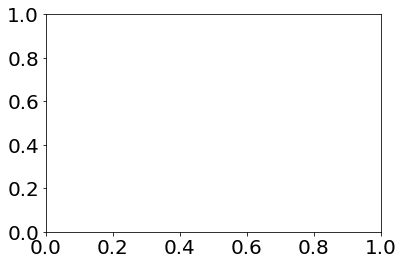

In [55]:


# Plot outputs
plt.scatter(X_test, y_test, color="black")
#plt.plot(, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

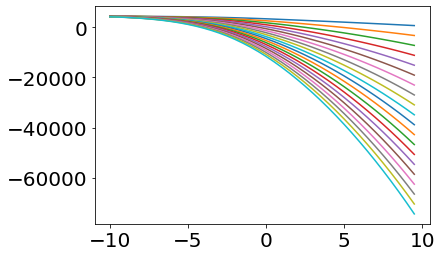

In [27]:
for melt_f in np.arange(10,1000, 50):
    sel = pd_spec_mb.loc[pd_spec_mb.melt_f == melt_f]
    plt.plot(sel['temp_bias'], sel['spec_mb_mean'])

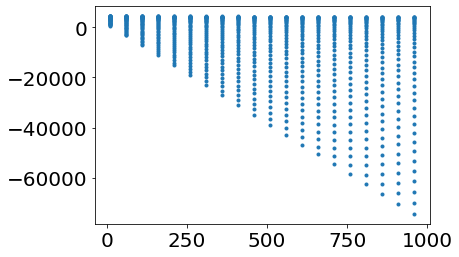

In [25]:
plt.plot(pd_spec_mb['melt_f'], pd_spec_mb['spec_mb_mean'], '.')

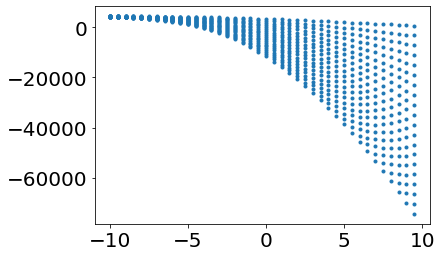

In [24]:
plt.plot(pd_spec_mb['temp_bias'], pd_spec_mb['spec_mb_mean'], '.')

In [7]:
rho_geodetic = 850

# get volume estimates
dV = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5'))

# for potential restricting total ice melt
V_gd_m3 = dV.loc[gd.rgi_id]['vol_itmix_m3']  # m3 volume of HEF
total_mass_gd = V_gd_m3 * rho_geodetic
# this is the area from 2000, could use another estimate (e.g. mean between 2000 and 2020...)
gd_area = pd_geodetic_loc.loc[gd.rgi_id]['area']  # in m2 now !!!
# convert kg --> kg/km2
max_allowed_specificMB = - total_mass_gd / gd_area

h, w = gd.get_inversion_flowline_hw()
if mb_type != 'mb_real_daily':
    cfg.PARAMS['baseline_climate'] = 'ERA5dr'
    oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5dr')
else:
    cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
    process_era5_daily_data(gd)

ref_df = gd.get_ref_mb_data()

# at instantiation use prcp_fac = 2.5, change this in def_get_mb later on
gd_mb = TIModel(gd, 150, mb_type=mb_type, N=100, prcp_fac=2.5,
                grad_type=grad_type)

NameError: name 'gd' is not defined

In [ ]:
bayes_calib_geod_direct.